# Multiple Kernel Learning
Research - Caio<>Nicholas

## 0. Import

In [1]:
using Statistics

In [2]:
include("../data/get_data.jl")
using .GetData: get_iris_data, get_adult_data

In [3]:
X_train, y_train, X_test, y_test = get_iris_data()

([-0.881336942370561 0.9796561672173504; -0.881336942370561 1.6501432778604033; … ; 0.6328542802044121 0.3091690565742975; -0.18247945502826546 1.6501432778604033], [1, 1, -1, -1, -1, -1, 1, -1, -1, -1  …  1, 1, 1, -1, 1, -1, -1, 1, -1, 1], [-1.114289438151325 -1.255300868259494; 2.147045502779384 -0.13782235052107178; … ; 1.2152355196563247 0.08567335302661286; -0.4154319508090306 -1.4787965718071787], [-1, -1, -1, 1, -1, -1, -1, 1, -1, -1  …  1, -1, -1, -1, -1, 1, -1, -1, -1, -1])

## 1. Simple SVM - Iris Dataset 2D

In [4]:
include("../src/SVM/svm.jl")
include("../src/SVM/plot_svm.jl")
using .SVM: compute_bias, predict_svm, kernel, train_svm
using .PlotSVM: meshgrid, plot_decision_boundary

### 1.1 Preprocess Iris Data


Kernel Type: linear
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 99.16666666666667 %
Testing Accuracy: 100.0 %


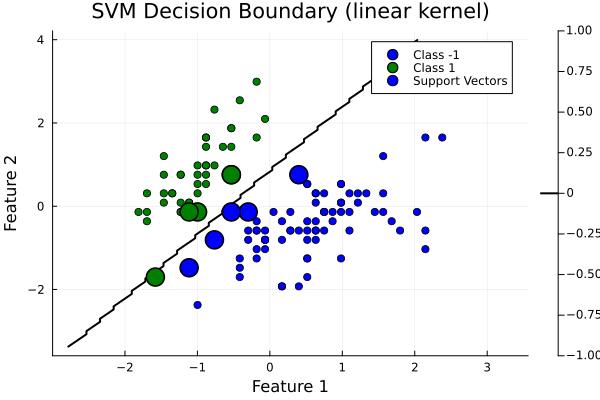


Kernel Type: polynomial
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 100.0 %
Testing Accuracy: 100.0 %


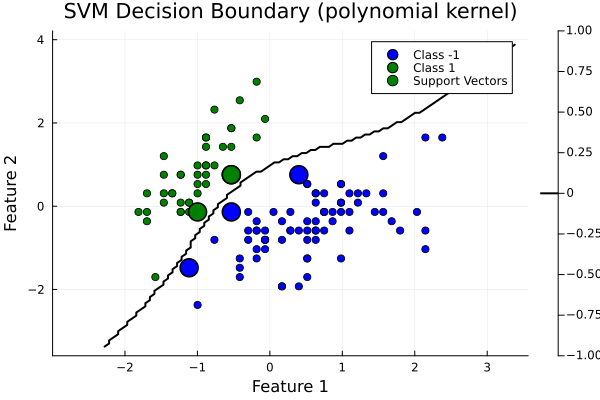


Kernel Type: rbf
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Training Accuracy: 99.16666666666667 %
Testing Accuracy: 100.0 %


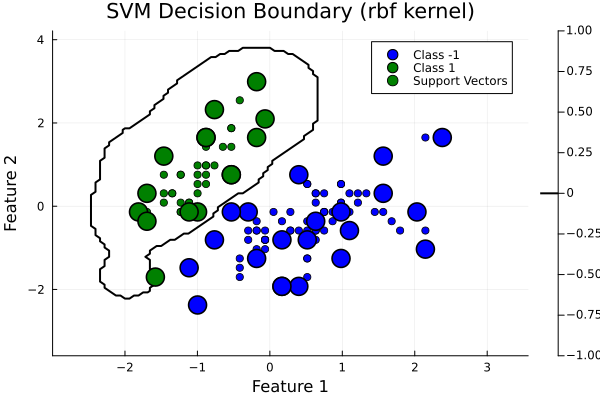

In [5]:
# Training parameters
C = 1.0
kernel_types = ["linear", "polynomial", "rbf"]  # List of kernels to test

for kernel_type in kernel_types
    println("\nKernel Type: $kernel_type")

    if kernel_type == "polynomial"
        degree = 3  # You can vary this
        γ = nothing  # Not used for polynomial
    elseif kernel_type == "rbf"
        γ = 2.0     # You can vary this
        degree = nothing  # Not used for RBF
    else
        degree = nothing
        γ = nothing
    end

    # Train the SVM model
    α, K_train = train_svm(X_train, y_train, C, kernel_type; degree=degree, gamma=γ)

    # Compute the bias term b
    b = compute_bias(α, y_train, K_train, C)

    # Make predictions on the training set
    y_pred_train = predict_svm(α, y_train, X_train, X_train, b, kernel_type;
                               degree=degree, gamma=γ)
    

    # Calculate training accuracy
    train_accuracy = mean(y_pred_train .== y_train) * 100
    println("Training Accuracy: $train_accuracy %")

    # Make predictions on the testing set
    y_pred_test = predict_svm(α, y_train, X_train, X_test, b, kernel_type;
                              degree=degree, gamma=γ)

    # Calculate testing accuracy
    test_accuracy = mean(y_pred_test .== y_test) * 100
    println("Testing Accuracy: $test_accuracy %")

    # Plot the decision boundary
    plot_decision_boundary(α, b, X_train, y_train, kernel_type; degree=degree, gamma=γ)
end

## Multi-kernel Learning

In [6]:
include("../src/MKL/multi_kernel.jl")
include("../src/MKL/plot_mkl.jl")
using .MKL: compute_kernels, train_mkl, compute_bias, predict_mkl
using .PlotMKL: plot_mkl_decision_boundary

Iteration 1...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 2...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 3...
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Converged after 3 iterations.
  0.987569 seconds (1.49 M allocations: 121.340 MiB, 5.75% gc time, 78.38% compilation time)
K_combined_new dimensions: (40, 120)
K_combined_new dimensions: (40, 30)
Training Accuracy: 100.0%
Test Accuracy: 100.0%
K_combined_new dimensions: (40, 90000)


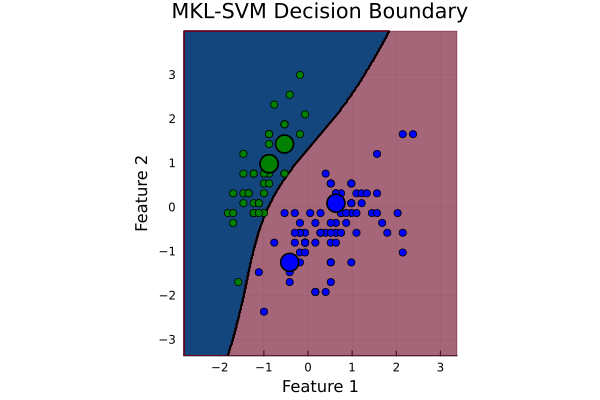

In [7]:
# Define parameters
C = 0.01
λ = 1  # Regularization for β
max_iter = 100
tolerance = 1e-3

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5))
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)


# Train MKL-SVM
@time begin
α, β, K_combined, list_alphas, list_betas = train_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance)
end

# Compute bias
b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

# Predict on training and test data
y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train; kernel_type="precomputed", tolerance=tolerance)
y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test; kernel_type="precomputed", tolerance=tolerance)

# Calculate accuracies
accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

# Print accuracies
println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")

# Plot decision boundary
plot_mkl_decision_boundary(α, y_train, X_train, β, b, C, kernels)

In [8]:
list_alphas

2-element Vector{Any}:
 [0.009999999998719537, 1.1613656065258466e-12, 2.0202813124651085e-12, 1.332661084558992e-12, 0.009999999998349822, 6.057909706866499e-12, 8.662831801908783e-13, 1.3105843667629342e-11, 7.455177134087315e-13, 5.903916332748354e-12  …  3.3376563153389845e-13, 3.190429477928595e-13, 0.009999999999361065, 8.824444340934569e-12, 2.0727289824331565e-12, 0.006252140486485547, 2.78583744444641e-12, 0.009999999999404454, 0.00999999999237697, 0.009999999999109622]
 [0.0066600394788890824, 6.454306258580645e-14, 3.7036823366877805e-13, 2.6105597070172457e-13, 0.009999999999726575, 1.08357572979081e-12, 6.892801082838335e-14, 1.98364887012314e-12, 1.3394631766022584e-13, 9.939961223635559e-13  …  3.4423027172669344e-14, 2.94822485555638e-14, 0.009999999999855506, 1.3460113162730808e-12, 9.292225090289516e-14, 9.277091928222172e-13, 6.41938434255428e-13, 0.009999999999859604, 0.009999999996320228, 0.009999999999705737]

In [9]:
list_betas

2-element Vector{Any}:
 [0.11536432235887076, 0.8343855915064301, 0.050250086134699175]
 [0.11960801322246034, 0.8191356906887445, 0.061256296088795334]

In [10]:
sum(α)

0.38115130988952484

## Interpretable Multi Kernel Learning

In [11]:
include("../src/MKL/multi_kernel.jl")
include("../src/MKL/plot_mkl.jl")
using .MKL: compute_kernels, train_mkl, compute_bias, predict_mkl
using .PlotMKL: plot_mkl_decision_boundary

include("../src/Interpretable_MKL/interpretable_multi_kernel.jl")
using .InterpretableMKL: sparse_optimize_beta, train_interpretable_mkl

In [12]:
include("../src/Interpretable_MKL/gssp.jl")

Main.GSSPAlgorithm

## Completing the Square in the MKL Objective

We focus on the \(\beta\)-dependent term:
$$
-\tfrac{1}{2}\,(y \circ \alpha)^{\top}\!\Bigl(\sum_{i=1}^q \beta_i\,K_i\Bigr)\!(y \circ \alpha)
\;+\;\lambda\,\|\beta\|_2^2.
$$

Let 
$$
v_i \;=\;(y \circ \alpha)^\top\,K_i\,(y \circ \alpha),
\quad
\text{so the expression becomes}
\quad
-\tfrac12 \sum_{i=1}^q \beta_i\,v_i \;+\;\lambda \sum_{i=1}^q \beta_i^2.
$$

Completing the square for each coordinate:
$$
\lambda\,\beta_i^2 - \tfrac{v_i}{2}\,\beta_i
\;=\;
\lambda\Bigl(\beta_i - \tfrac{v_i}{4\,\lambda}\Bigr)^2
\;-\;\tfrac{v_i^2}{16\,\lambda}.
$$

Summing over $i=1,\dots,q$ yields
$$
-\tfrac12 \sum_{i=1}^q \beta_i\,v_i \;+\;\lambda \sum_{i=1}^q \beta_i^2
\;=\;
\lambda\,\|\boldsymbol{\beta} - \boldsymbol{w}\|_2^2
\;-\;\tfrac{1}{16\,\lambda}\,\|\boldsymbol{v}\|_2^2,
\quad
\text{where}
\quad
w_i \;=\;\tfrac{v_i}{4\,\lambda}.
$$

Thus, up to the constant 
$-\,\tfrac{1}{16\,\lambda}\|\boldsymbol{v}\|_2^2$, the $\beta\$-term is
$$
\lambda\\|\boldsymbol{\beta} - \boldsymbol{w}\\|_2^2.
$$


Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 1...
w_sub: [0.48751020031041764, 4.19856880543512, 1.472009365954522]
β_sub: [1.7681474097437313, 5.479206014868434, 2.7526465753878355]
β: [1.7681474097437313, 5.479206014868434, 2.7526465753878355, 0.0, 0.0, 0.0]
Objective function: -50.60545524053284
Iteration 2...
w_sub: [0.0013969409950589753, 0.012697137508849222, 0.004769943136568246]
β_sub: [3.3284422671149, 3.3397424636286903, 3.3318152692564094]
β: [3.3284422671149, 3.3397424636286903, 3.3318152692564094, 0.0, 0.0, 0.0]
Objective function: 0.21478603563497212
Iteration 3...
w_sub: [0.0025098474064356975, 0.023371250329213698, 0.00868947474561675]
β_sub: [3.324319656579347, 3.345181059502125, 3.330499283918528]
β: [3.324319656579347, 3.345181059502125, 3.330499283918528, 0.0, 0.0, 0.0]
Objective function: 0.2305084683971806
Iteration 4...
w_sub: [0.0025054405153537925, 0.023328285231695764, 0.008673808780196801]
β_sub: [3.3243

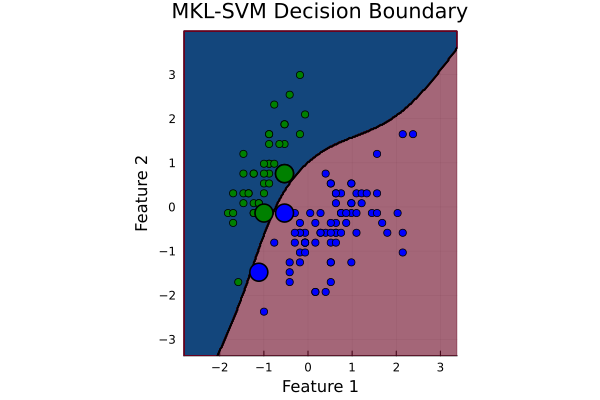

In [19]:
# Define parameters
C = 1
k0 = 3
λ = 1.0 # Regularization for β
sum_beta_val = 10.0
max_iter = 50
tolerance = 1e-5

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "polynomial", :params => Dict(:degree => 2, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.3)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.1))
    
    
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)

y_train = Float64.(y_train)
C = float(C)

# Train MKL-SVM
@time begin
    α, β, K_combined, list_alphas, list_betas = train_interpretable_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance, k0=k0, sum_beta_val=sum_beta_val)
end

# Compute bias
b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

# Predict on training and test data
y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train, kernel_type="precomputed"; tolerance=tolerance)
y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test, kernel_type="precomputed"; tolerance=tolerance)

# Calculate accuracies
accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

# Print accuracies
println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")

# Plot decision boundary
plot_mkl_decision_boundary(α, y_train, X_train, β, b, C, kernels)

## Proximal Algo

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 1...
Δ: [-0.17795140108541807, -2.5727286725171106, -0.6344231669929231, -0.105718768925536, -0.07387908401704768, -0.02912175976974346]
keep_inds: [2, 3, 1]
β_new: [0.19903465691608377, 0.44627373787042773, 0.2646242082581294, 0.0, 0.0, 0.0]
β: [0.19903465691608377, 0.44627373787042773, 0.2646242082581294, 0.0, 0.0, 0.0]
Objective function: 0.5114710747297408
Iteration 2...
Δ: [-0.05345902831260896, -1.0730313163859622, -0.23634977193147266, -0.0005903381072024529, -0.0002724309777103097, -4.018340444360047e-5]
keep_inds: [2, 3, 1]
β_new: [0.20772569227803486, 0.5201108791922526, 0.2927891267502567, 0.0, 0.0, 0.0]
β: [0.20772569227803486, 0.5201108791922526, 0.2927891267502567, 0.0, 0.0, 0.0]
Objective function: 1.531706780907871
Iteration 3...
Δ: [-0.04234220190150406, -0.9441149479207116, -0.19803797107323295, -0.00034558135890616664, -0.00015727770821813886, -2.3307463886556615e-5]


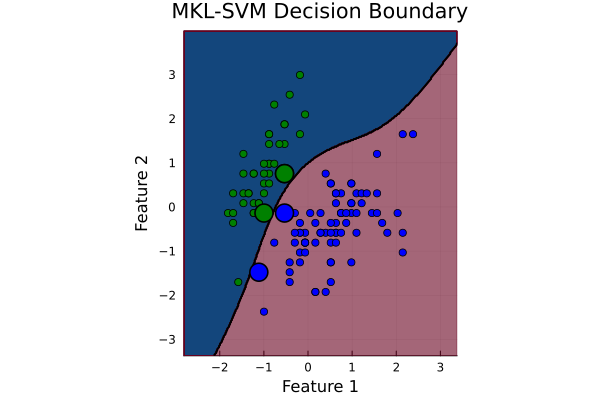

In [16]:
# Define parameters
C = 1
k0 = 3
λ = 0.01 # Regularization for β
sum_beta_val = 1.0
max_iter = 50
tolerance = 1e-5

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "polynomial", :params => Dict(:degree => 2, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.3)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.1))
    
    
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)

y_train = Float64.(y_train)
C = float(C)

# Train MKL-SVM
@time begin
    α, β, K_combined, list_alphas, list_betas = train_interpretable_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance, k0=k0, sum_beta_val=sum_beta_val)
end

# Compute bias
b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

# Predict on training and test data
y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train, kernel_type="precomputed"; tolerance=tolerance)
y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test, kernel_type="precomputed"; tolerance=tolerance)

# Calculate accuracies
accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

# Print accuracies
println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")

# Plot decision boundary
plot_mkl_decision_boundary(α, y_train, X_train, β, b, C, kernels)

## Next Steps

In [ ]:
- speeding up the SVM α sub-problem
- Validation on different datasets
- Benchmark methods that we want to compare against (somewhat recent implemented methods)


## Exploring method in Adult dataset

In [9]:
X_train, y_train, X_test, y_test = get_adult_data()

LoadError: UndefVarError: `get_adult_data` not defined

In [10]:
# Define parameters
C = 1
k0 = 3
λ = 0.1  # Regularization for β
max_iter = 50
tolerance = 1e-5

# Define kernel specifications
kernels = [
    Dict(:type => "linear", :params => Dict()),
    Dict(:type => "polynomial", :params => Dict(:degree => 3, :c => 1.0)),
    Dict(:type => "polynomial", :params => Dict(:degree => 2, :c => 1.0)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.5)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.3)),
    Dict(:type => "rbf", :params => Dict(:gamma => 0.1))
    
    
]

# Compute kernels for training and test
K_list_train = compute_kernels(X_train, X_train, kernels)
K_list_test = compute_kernels(X_train, X_test, kernels)

y_train = Float64.(y_train)
C = float(C)

LoadError: UndefVarError: `compute_kernels` not defined

In [20]:
using Profile

@profile begin
    # Time the train_mkl function
    α, β, K_combined = train_interpretable_mkl(X_train, y_train, C, K_list_train, λ; max_iter=max_iter, tolerance=tolerance, k0=k0)

    # Compute bias
    b = compute_bias(α, y_train, K_combined, C; tolerance=tolerance)

    # Predict on training and test data
    y_pred_train = predict_mkl(α, y_train, X_train, X_train, β, b, K_list_train, kernel_type="precomputed"; tolerance=tolerance)
    y_pred_test = predict_mkl(α, y_train, X_train, X_test, β, b, K_list_test, kernel_type="precomputed"; tolerance=tolerance)

    # Calculate accuracies
    accuracy_train = sum(y_train .== y_pred_train) / length(y_train)
    accuracy_test = sum(y_test .== y_pred_test) / length(y_test)

    # Print accuracies
    println("Training Accuracy: ", round(accuracy_train * 100, digits=2), "%")
    println("Test Accuracy: ", round(accuracy_test * 100, digits=2), "%")
end

# Print profiling results
Profile.print()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-18
Iteration 1...
β: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Objective function: 457.76400234238724
Iteration 2...
β: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Objective function: -1.3738106701771864e8
Iteration 3...
β: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Objective function: 337.66613413741015
Iteration 4...
β: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Objective function: -1.3738106701771864e8
Iteration 5...
β: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Objective function: 337.66613413741015
Iteration 6...
β: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Objective function: -1.3738106701771864e8
Iteration 7...
β: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Objective function: 337.66613413741015
Iteration 8...
β: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Objective function: -1.3738106701771864e8
Iteration 9...
β: [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Objective function: 337.66613413741015
Iteration 10...
β: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Objective function: -1.3738106701771864e8
Iteration 11.

┌ Warning: The profile data buffer is full; profiling probably terminated
│ before your program finished. To profile for longer runs, call
│ `Profile.init()` with a larger buffer and/or larger delay.
└ @ Profile /Applications/Julia-1.10.4.app/Contents/Resources/julia/share/julia/stdlib/v1.10/Profile/src/Profile.jl:609


Overhead ╎ [+additional indent] Count File:Line; Function
      ╎13     @Base/asyncevent.jl:306; (::Base.var"#726#727"{typeof(IJulia.send…
      ╎ 13     @IJulia/src/stdio.jl:124; send_stdout
      ╎  13     @IJulia/src/stdio.jl:121; send_stdio(name::String)
     1╎   1      @IJulia/src/stdio.jl:141; send_stream(name::String)
      ╎   12     @IJulia/src/stdio.jl:163; send_stream(name::String)
      ╎    1      @IJulia/src/msg.jl:30; msg_pub
      ╎     1      @IJulia/src/msg.jl:30; msg_pub
      ╎    ╎ 1      @IJulia/src/msg.jl:18; msg_header(m::IJulia.Msg, msg_type::…
      ╎    ╎  1      …__IAI_v3_2_1.dylib:?; now()
     1╎    ╎   1      …_IAI_v3_2_1.dylib:?; Base.Libc.TmStruct(t::Int64)
      ╎    5      @IJulia/src/msg.jl:48; send_ipython(socket::ZMQ.Socket, m::IJ…
      ╎     5      @ZMQ/src/comm.jl:37; send
      ╎    ╎ 5      @ZMQ/src/comm.jl:40; send(socket::ZMQ.Socket, data::String;…
      ╎    ╎  5      @ZMQ/src/comm.jl:8; _send(socket::ZMQ.Socket, zmsg::Base.R…
     5╎    ╎

In [22]:
using Printf

function print_confusion_metrics(y_actual, y_pred, set_name="Data Set")
    println("---------------" * set_name * "---------------")
    println("")
    # Initialize counts
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for i in 1:length(y_actual)
        actual = y_actual[i]
        predicted = y_pred[i]
        if actual == 1 && predicted == 1
            TP += 1
        elseif actual == -1 && predicted == -1
            TN += 1
        elseif actual == -1 && predicted == 1
            FP += 1
        elseif actual == 1 && predicted == -1
            FN += 1
        end
    end

    # Print confusion matrix
    println("Confusion Matrix ($set_name):")
    println("            Predicted")
    println("            -1     +1")
    println(@sprintf("Actual -1   %-6d %-6d", TN, FP))
    println(@sprintf("       +1   %-6d %-6d", FN, TP))

    # Compute precision, recall, and F1-score
    precision = (TP + FP == 0) ? 0 : TP / (TP + FP)
    recall = (TP + FN == 0) ? 0 : TP / (TP + FN)
    f1_score = (precision + recall == 0) ? 0 : 2 * (precision * recall) / (precision + recall)

    println("Precision: ", precision)
    println("Recall: ", recall)
    println("F1-score: ", f1_score)
    println("")
end

# Example usage:
print_confusion_metrics(y_train, y_pred_train, "Train Set")
print_confusion_metrics(y_test, y_pred_test, "Test Set")

---------------Train Set---------------

Confusion Matrix (Train Set):
            Predicted
            -1     +1
Actual -1   966    1     
       +1   324    11    
Precision: 0.9166666666666666
Recall: 0.03283582089552239
F1-score: 0.06340057636887607

---------------Test Set---------------

Confusion Matrix (Test Set):
            Predicted
            -1     +1
Actual -1   263    0     
       +1   63     0     
Precision: 0
Recall: 0.0
F1-score: 0



### 

1. Try to use other Julia SVM solver to accelerate algorithm
2. Method 3. for proximal algorithm -> also, see what happens without it
3. Method 2 for dual ascent

## Discussions: 
1. **Normalization of betas at each iteration**: I could only make it work with it
2. **Runtime**: to run the adult dataset, I needed to sample a small part (5%) of data set and took 8min. Do we have any other ideas to speed up or is this normal? 
    - I already did some optimization on the compute_kernels code
    - Ideas: parallelize, run profiler to understand why it is taking so long, etc. 

## Next Steps

- Can be worth taking a look at this sparsePCA -> idea, maybe take out of objective and add a constraint in beta
- profiler seems to be a great idea
- look at other packages for MKL -> see if they have this scalling problem as well
- trying to figure out what optimization problem it is actually solving
- plotting/understanding relationship of lambda and norm(\beta)

## Previous Prioritized Next Steps
- Priority: 1, then 2/3 equally
- We are concerned with run-time. Try to take out gurobi as much as possible. 

1. Sparse Constraints (see trick below from class) **(DONE)**
2. Come up with universe of existing methods that we want to compare with (get papers with Nicholas)
 - Find open source implementation of their code
 - Other methods to solve the multiple kernel learning problem (can be non-sparse), e.g. L1-penalize problem - kind of similar to Lasso
 - No need to implement it
3. Reasonable dataset to test our model (can choose UCI or area I like)